## 导入库 

In [31]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
import pandas as pd
import scikitplot
import math
import time
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
from keras import backend as K

Using TensorFlow backend.


## 参数

In [2]:
INPUT_PATH = "./data/"
INPUT_SHAPE = (48, 48, 1)
batch_size = 10
epochs = 10

## 导入数据 

### 数据数量

In [3]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    total_images += count
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images: {total_images}")

anger has 135 number of images
contempt has 54 number of images
disgust has 177 number of images
fear has 75 number of images
happy has 207 number of images
sadness has 84 number of images
surprise has 249 number of images

total images: 981


### 标签

In [4]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

### 数据img_arr和数据标签img_label
expand_dims 在数组中扩展位置，这里也可以采用tf.expand_dims 或者采用tf.resize

In [6]:
img_arr = np.empty(shape=(total_images, 48, 48, 1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

idx = 0
label = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in  TOP_EMOTIONS:
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[idx] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[idx] = label
            idx += 1
        label_to_text[label] = dir_
        label += 1

img_label = keras.utils.to_categorical(img_label)

img_arr.shape, img_label.shape, label_to_text

((981, 48, 48, 1),
 (981, 5),
 {0: 'anger', 1: 'fear', 2: 'happy', 3: 'sadness', 4: 'surprise'})

### 数据集切割

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((686, 48, 48, 1), (295, 48, 48, 1))

### 展示图片

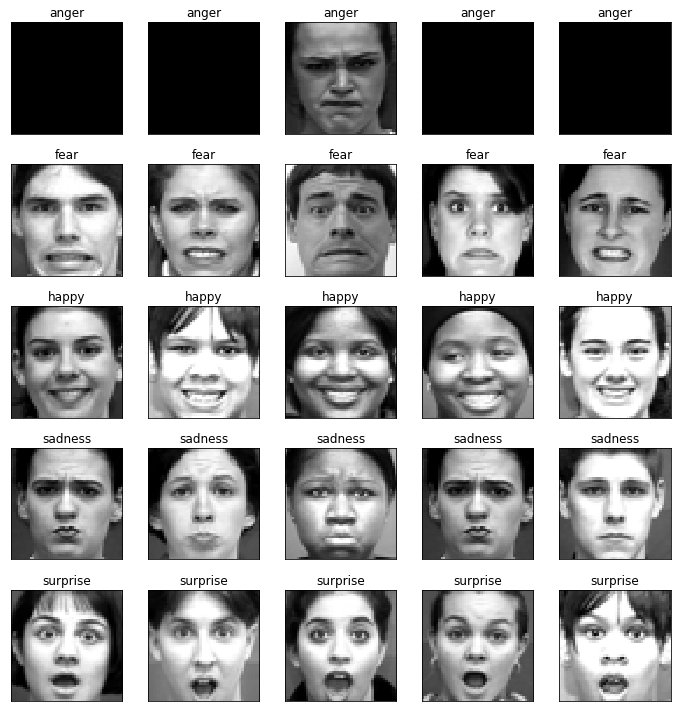

In [8]:
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(y_train[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5, 5, idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

### 归一化 

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.

## 定义模型

In [13]:
def build_dcnn(input_shape, num_classes):
    model_in = keras.layers.Input(shape=input_shape, name="input")
    
    conv2d_1 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_1')(model_in)
    batchnorm_1 = keras.layers.BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_2')(batchnorm_1)
    batchnorm_2 = keras.layers.BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = keras.layers.Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_3')(dropout_1)
    batchnorm_3 = keras.layers.BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_4')(batchnorm_3)
    batchnorm_4 = keras.layers.BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = keras.layers.Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_5')(dropout_2)
    batchnorm_5 = keras.layers.BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_6')(batchnorm_5)
    batchnorm_6 = keras.layers.BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = keras.layers.Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = keras.layers.Flatten(name='flatten')(dropout_3)
    
    dense_1 = keras.layers.Dense( 128, activation='relu', kernel_initializer='he_normal', name='dense1')(flatten)
    batchnorm_7 = keras.layers.BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = keras.layers.Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = keras.layers.Dense( num_classes, activation='softmax', name='out_layer')(dropout_4)

    model = keras.models.Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [14]:
model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0      

### 损失和优化

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

## callbacks

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00008, patience=12, verbose=1, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau( monitor='val_accuracy', min_delta=0.0001, factor=0.4, patience=6, min_lr=1e-7, verbose=1)

callbacks = [early_stopping, lr_scheduler,]

## 开始训练

In [17]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train on 686 samples, validate on 295 samples
Epoch 1/10
686/686 [==============================] - 4s 5ms/sample - loss: 0.9253 - accuracy: 0.6822 - val_loss: 2.6119 - val_accuracy: 0.3627
Epoch 2/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.5081 - accuracy: 0.8338 - val_loss: 0.9543 - val_accuracy: 0.5051
Epoch 3/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.3329 - accuracy: 0.8892 - val_loss: 0.9637 - val_accuracy: 0.6644
Epoch 4/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.2753 - accuracy: 0.9052 - val_loss: 0.7023 - val_accuracy: 0.7220
Epoch 5/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.2694 - accuracy: 0.9184 - val_loss: 0.3383 - val_accuracy: 0.8949
Epoch 6/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.1898 - accuracy: 0.9388 - val_loss: 0.1426 - val_accuracy: 0.9627
Epoch 7/10
686/686 [==============================] - 1s 1ms/sample - loss: 0.1017 - accur

## 绘制梯度图 

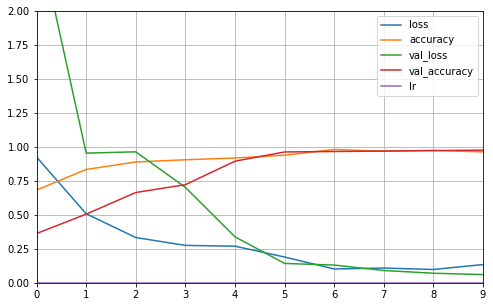

In [18]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    pyplot.grid(True)
    pyplot.gca().set_ylim(0, 2)
    pyplot.show()
    
plot_learning_curves(history)

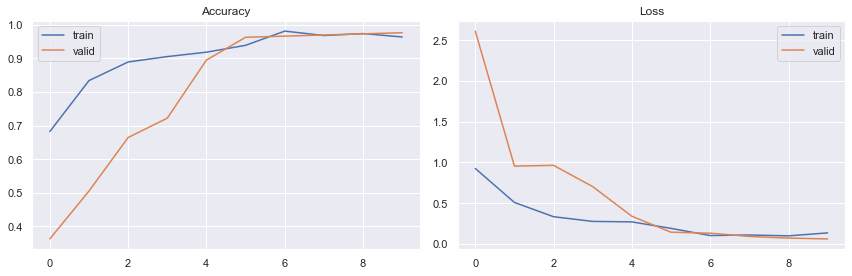

In [19]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [21]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 0, 'fear': 1, 'happy': 2, 'sadness': 3, 'surprise': 4}

test accuracy: 97.6271 %


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       110
           1       0.95      0.87      0.91        23
           2       1.00      0.98      0.99        62
           3       1.00      0.88      0.94        25
           4       0.96      1.00      0.98        75

    accuracy                           0.98       295
   macro avg       0.98      0.95      0.96       295
weighted avg       0.98      0.98      0.98       295



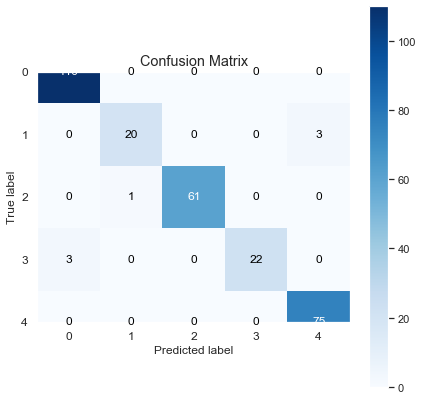

In [22]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(sklearn.metrics.classification_report(ytest_, yhat_test))

In [23]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x173f7c8c808>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x173f7c8e688>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x16d34496b88>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x16d344af588>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x173f646ef88>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x173f6486a48>)]

## 绘制过滤器

In [24]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

Wall time: 36.2 s


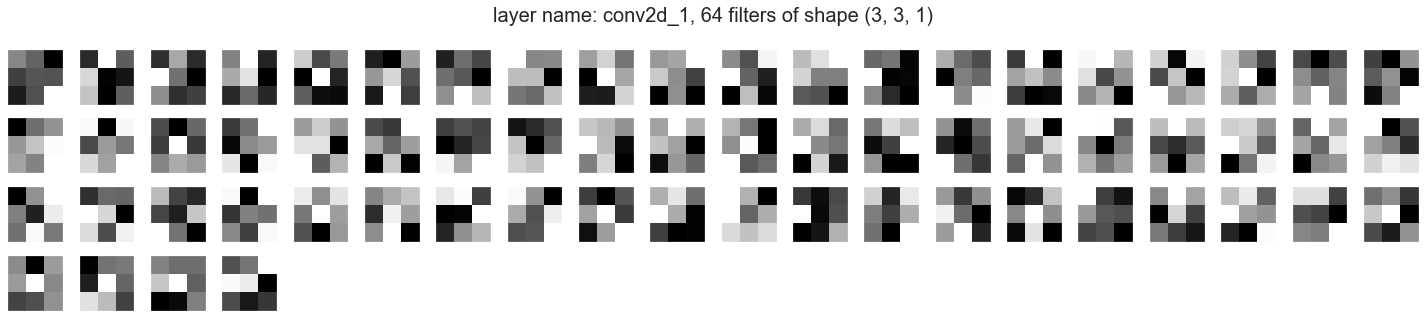

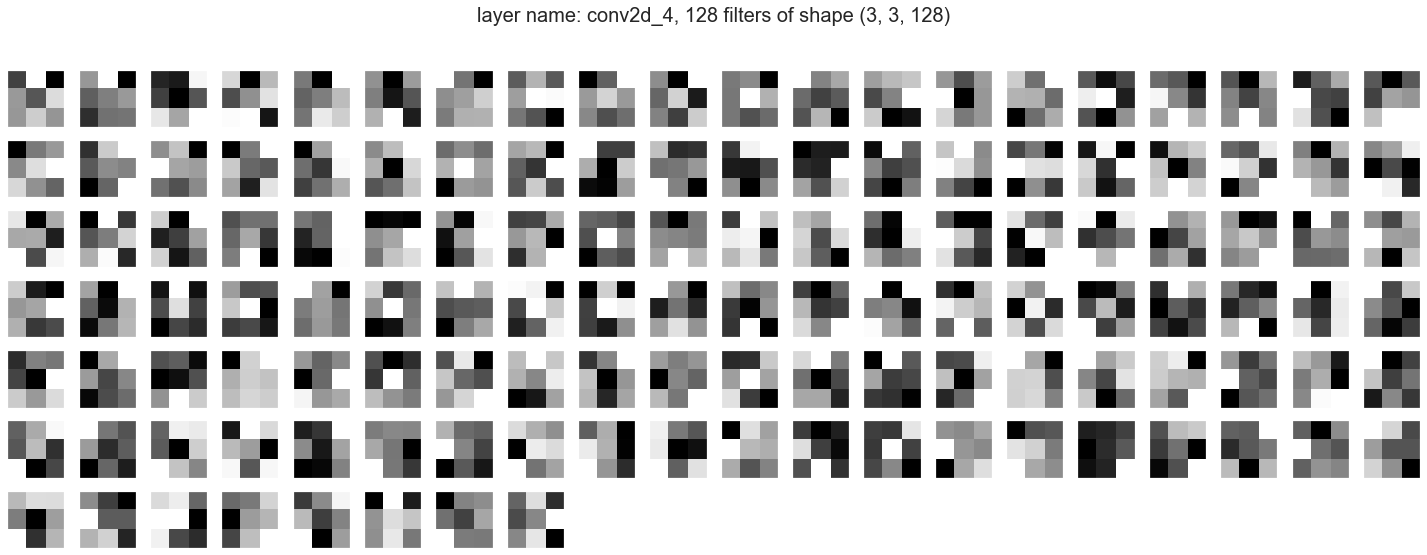

In [25]:
%%time

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()
        filters = (filters - filters.min()) / (filters.max() - filters.min())
    
        cols = 20
        rows = math.ceil(filters.shape[-1] / cols)
        fig = pyplot.figure(idx, (20, rows))

        idx += 1
        for i, f in enumerate(np.rollaxis(filters, 3)):
            ax = pyplot.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
            pyplot.tight_layout()

## 绘制特征图

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

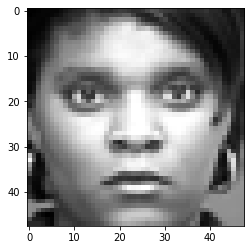

In [26]:
sns.reset_orig()
sample_img = X_test[0]
pyplot.imshow(sample_img.reshape(48, 48), cmap="gray")
pyplot.show()

In [27]:
sample_img = np.expand_dims(sample_img, axis=0)
sample_img.shape

(1, 48, 48, 1)

## 绘制原图 进行了特征提取

In [28]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

Wall time: 27.6 s


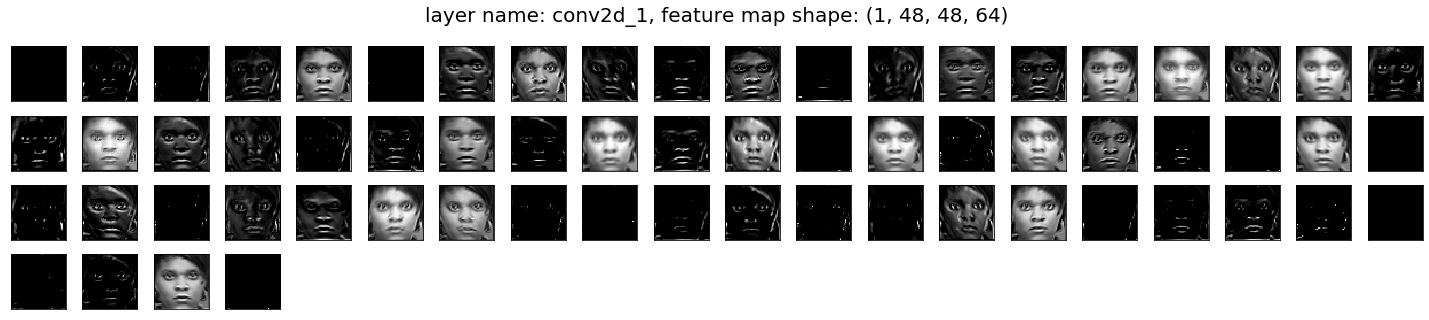

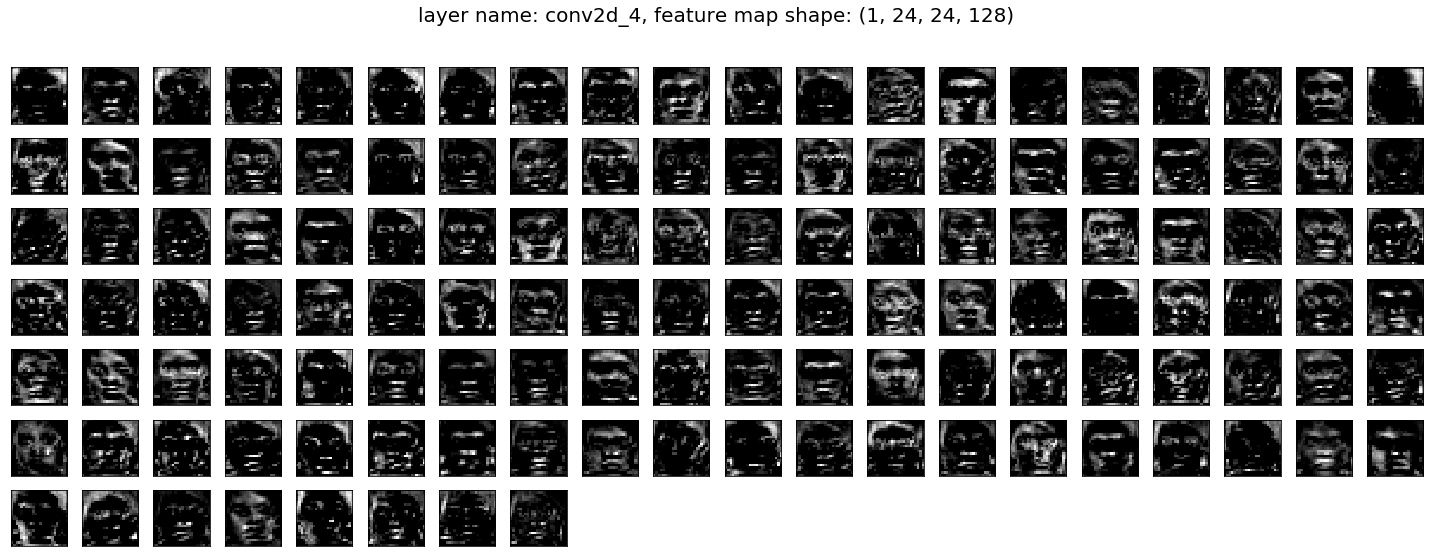

In [30]:
%%time

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = keras.models.Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = pyplot.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

## 绘图类激活图（CAM）

In [32]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_2", "conv2d_3", "conv2d_4", "conv2d_5", "conv2d_6"]

In [33]:
preds = model.predict(sample_img)
label_to_text[np.argmax(preds[0])]

'surprise'

In [34]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>

In [35]:
heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([sample_img])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:713: UserWarning: Wa

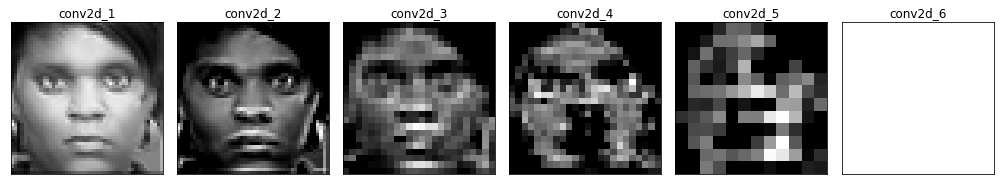

In [36]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

## 我们可以看到我们的模型专注于图像的重要方面，即嘴唇，眼睛和眉毛。 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


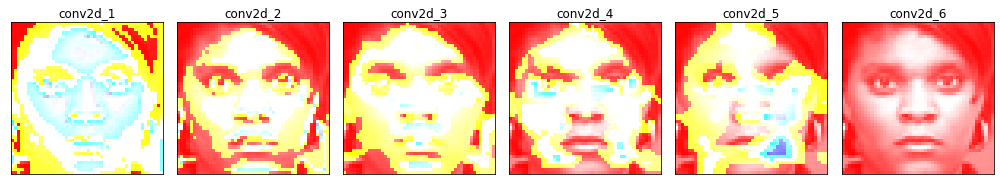

In [37]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    img_hm = cv2.resize(img_heatmap, (48,48))
    img_hm = np.uint8(255 * img_hm)

    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    superimposed_img = img_hm * 0.4 + sample_img

    ax = pyplot.subplot(1, 6, i+1)
    ax.imshow(superimposed_img[0,:,:])
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()